In [2]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/stage_3_chronos_vs_arima', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [3]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-ocn0c01i
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-ocn0c01i
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Finalized forecast plotting function for FYP/paper

In [1]:
import matplotlib.pyplot as plt

# ======================
# Finalized Forecasting Plot Function
# ======================

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["figure.figsize"] = (14, 8)

custom_palette = {
    "historical": "#333333",           # dark grey for historical data
    "ground_truth": "#0077CC",         # bright blue for ground truth
    "forecast": "#FFA500",             # orange for forecast median
    "prediction_interval": "#FF7F0E",  # bright orange for uncertainty band
}


def plot_forecasts(data, start_idx, forecasts, method, historical_window, FORECAST_STEPS):
    """Plot forecasting results with historical data, ground truth, and model predictions."""

    fig, ax = plt.subplots()

    # Historical data (context window before forecast start)
    context_data = data.iloc[start_idx - historical_window : start_idx + 1]
    ax.plot(
        context_data["Date"],
        context_data["Close"],
        label="Historical Data",
        color=custom_palette["historical"],
        linewidth=1.75,
    )

    # Ground truth for the forecast period
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    ax.plot(
        actual_data["Date"],
        actual_data["Close"],
        label="Ground Truth",
        color=custom_palette["ground_truth"],
        linewidth=1.75,
    )

    # Forecast median and uncertainty band
    ax.plot(
        forecasts["dates"],
        forecasts["median"],
        label=f"{method.capitalize()} Prediction",
        color=custom_palette["forecast"],
        linewidth=1.75,
    )
    ax.fill_between(
        forecasts["dates"],
        forecasts["low"],
        forecasts["high"],
        color=custom_palette["forecast"],
        alpha=0.4,
    )

    # Labels and title
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    ax.set_title(
        f"S&P 500 Price Prediction ({method.capitalize()}) - {method} Model",
        fontsize=14,
    )

    # Tick formatting
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Legend
    ax.legend(fontsize=10, frameon=True)

    # Grid and layout
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Chronos multi-step autoregressive

[4175.51196289 4178.66015625 4181.80834961 4178.66015625 4184.95654297
 4188.10498047 4188.10498047 4188.10498047 4197.55004883 4216.43945312
 4229.03271484 4219.58789062 4216.43945312 4213.29125977 4216.43969727
 4210.14306641 4219.58789062 4222.73608398 4225.88452148 4238.4777832
 4235.32958984]
DatetimeIndex(['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29'],
              dtype='datetime64[ns]', freq='B')


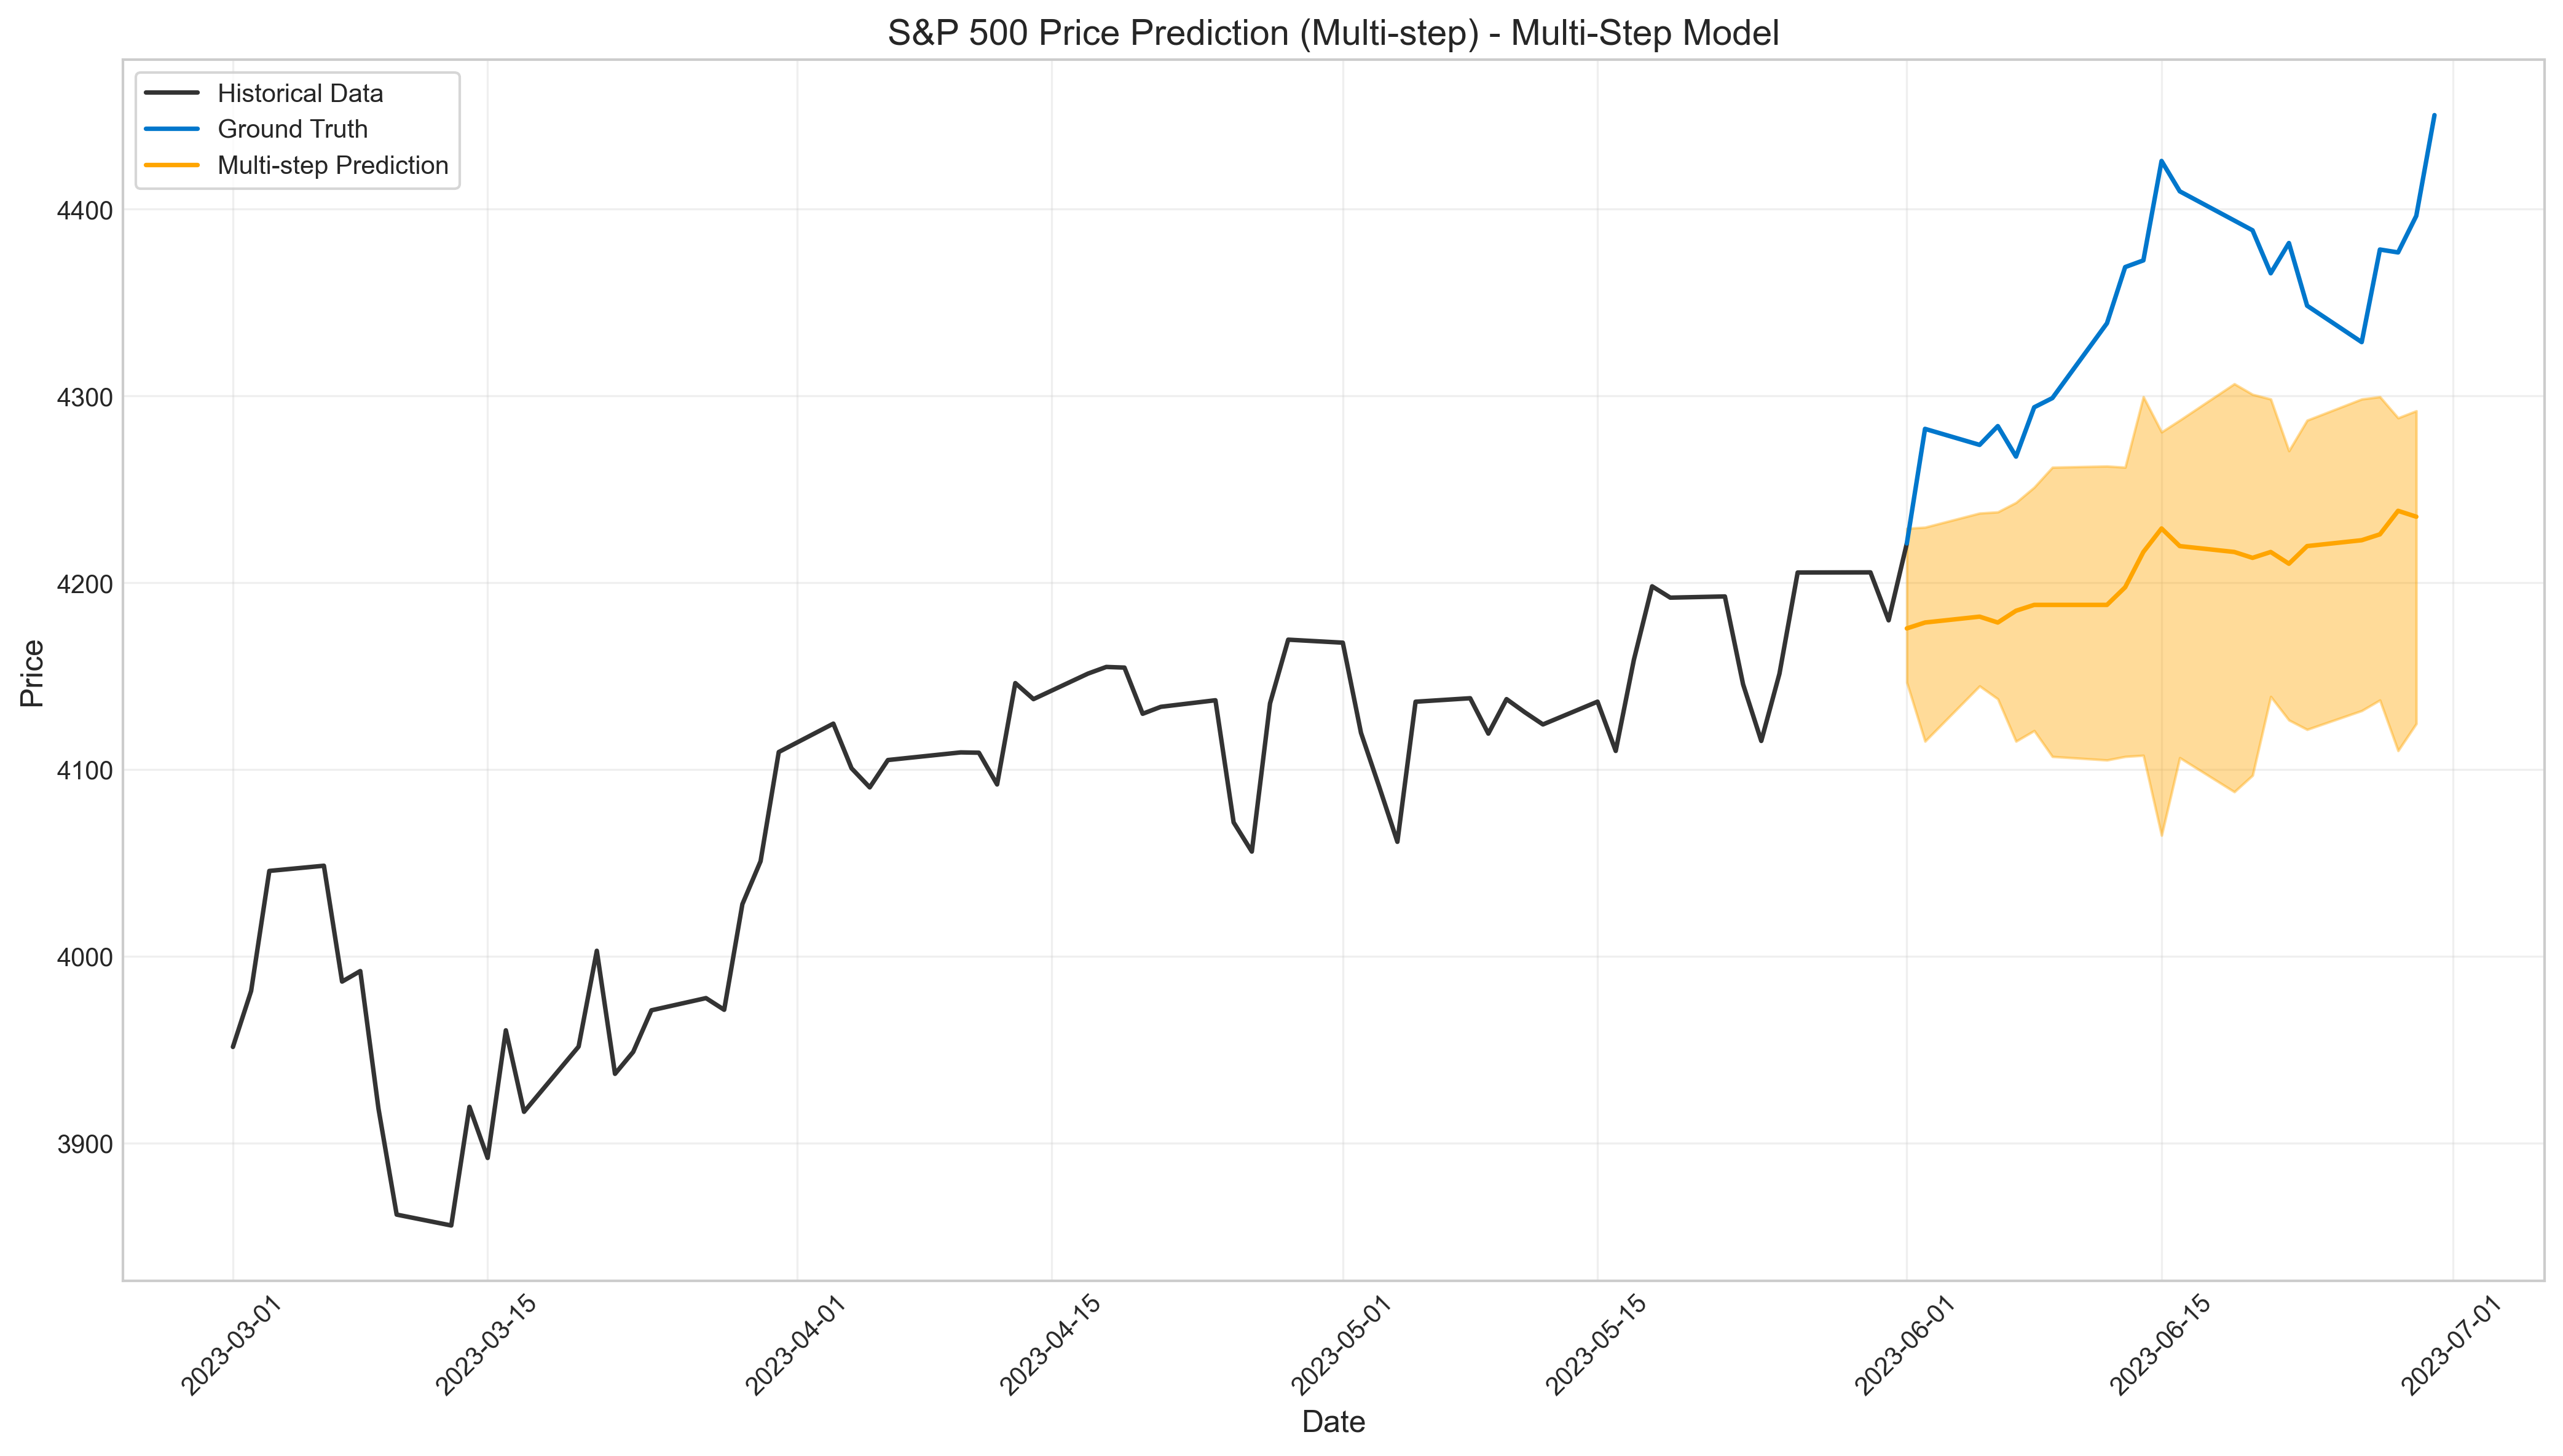


Chronos Multi-step Forecast Metrics:
MAE: 139.4275
MSE: 21120.3946
RMSE: 145.3286
Z-NormalizedMAE: 2.4017
Z-NormalizedMSE: 6.2666
Z-NormalizedRMSE: 2.5033
MAPE: 3.1968
SMAPE: 3.2531
MASE: 5.1553
DirectionalAccuracy: 26.3158


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_5150/3153924255.py:80: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  historical_last_point = float(data['Close'].iloc[start_idx - 1])


In [6]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Best performing multi-step windows: (1750, 64) and (1600, 21)

CONTEXT_WINDOW = 1600
FORECAST_STEPS = 21
PREDICTION_LENGTH = 1

sp500_d = snp500_daily

pipeline = ChronosPipeline.from_pretrained(
    # "./ft_chronos_sp500_closing_rk2/checkpoint-final",
    # "./ft_chronos_tiny_rk2_3000/checkpoint-final",
    "amazon/chronos-t5-large",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class ChronosMultiStepAheadForecaster:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        self.scaler.fit(data.reshape(-1, 1))

    def generate_multi_step_forecast_quantiles(self, context_data, horizon=FORECAST_STEPS):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)

        with torch.no_grad():
            forecast = pipeline.predict(context_tensor, horizon)

        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)

        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)

        return low_arr, median_arr, high_arr

    def get_multi_step_forecasts(self, data, start_idx):
        all_forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}

        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        self.fit_scaler(context_data)

        low_arr, median_arr, high_arr = self.generate_multi_step_forecast_quantiles(context_data, horizon=FORECAST_STEPS)
        print(median_arr)

        forecast_dates = pd.date_range(start=data['Date'].iloc[start_idx], periods=FORECAST_STEPS, freq='B')
        print(forecast_dates)

        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates

        return all_forecasts

def run_experiment(data, target_date, method="Multi-Step"):
    predictor = ChronosMultiStepAheadForecaster()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    forecasts = predictor.get_multi_step_forecasts(data, start_idx)
    plot_forecasts(data, start_idx, forecasts, method, 64, FORECAST_STEPS)

    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    insample_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].values
    historical_last_point = float(data['Close'].iloc[start_idx - 1])

    metrics = calculate_metrics(
        actual_values, 
        np.array(forecasts['median']), 
        insample=insample_data,
        historical_last_point=historical_last_point,
        directional_accuracy=True,
        )
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2023-05-31", method="Multi-Step")

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_5150/2595167014.py:112: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



----- DATA FOR MANUAL VALIDATION -----
Historical last point: 4221.02001953125
Actual values: [[4282.37011719]
 [4273.79003906]
 [4283.85009766]
 [4267.52001953]
 [4293.93017578]
 [4298.85986328]
 [4338.93017578]
 [4369.00976562]
 [4372.58984375]
 [4425.83984375]
 [4409.58984375]
 [4388.70996094]
 [4365.68994141]
 [4381.89013672]
 [4348.33007812]
 [4328.81982422]
 [4378.41015625]
 [4376.85986328]
 [4396.43994141]
 [4450.37988281]
 [4455.58984375]
 [4446.81982422]
 [4411.58984375]
 [4398.95019531]
 [4409.52978516]
 [4439.25976562]
 [4472.16015625]
 [4510.04003906]
 [4505.41992188]
 [4522.79003906]
 [4554.97998047]
 [4565.72021484]
 [4534.87011719]
 [4536.33984375]
 [4554.64013672]
 [4567.45996094]
 [4566.75      ]
 [4537.41015625]
 [4582.22998047]
 [4588.95996094]
 [4576.72998047]
 [4513.39013672]
 [4501.89013672]
 [4478.02978516]
 [4518.43994141]
 [4499.37988281]
 [4467.70996094]
 [4468.83007812]
 [4464.04980469]
 [4489.72021484]
 [4437.85986328]
 [4404.33007812]
 [4370.35986328]
 [43

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3

ARIMA predictions: [4224.533502860737, 4281.783480513898, 4275.258556359082, 4282.5548404217725, 4268.13812375043, 4294.442723177025, 4296.829294131828, 4342.215282929663, 4368.357722048813, 4373.161134631917, 4422.097413815587, 4406.784965734794, 4388.076709452315, 4366.598839460252, 4381.495630987708, 4349.67038588323, 4330.686583588465, 4377.244902363118, 4371.2050688632335, 4390.526578434072, 4446.865337795902, 4452.8645610515005, 4441.336379875959, 4406.4924907022405, 4394.280990765308, 4404.730748980807, 4434.106829703467, 4467.120606467123, 4504.891016003859, 4500.672633611401, 4520.63381710901, 4552.272633514088, 4564.0450692090435, 4534.698865570459, 4536.053858577163, 4553.699386841779, 4566.097995308963, 4565.805203388468, 4538.069228133015, 4580.63308310104, 4587.516387115258, 4576.351188001095, 4516.27691729414, 4504.647284894335, 4481.198055353693, 4518.6390396849965, 4500.507458496843, 4470.1908824480415, 4470.568051802811, 4465.544854075028, 4489.48894907724, 4440.33607

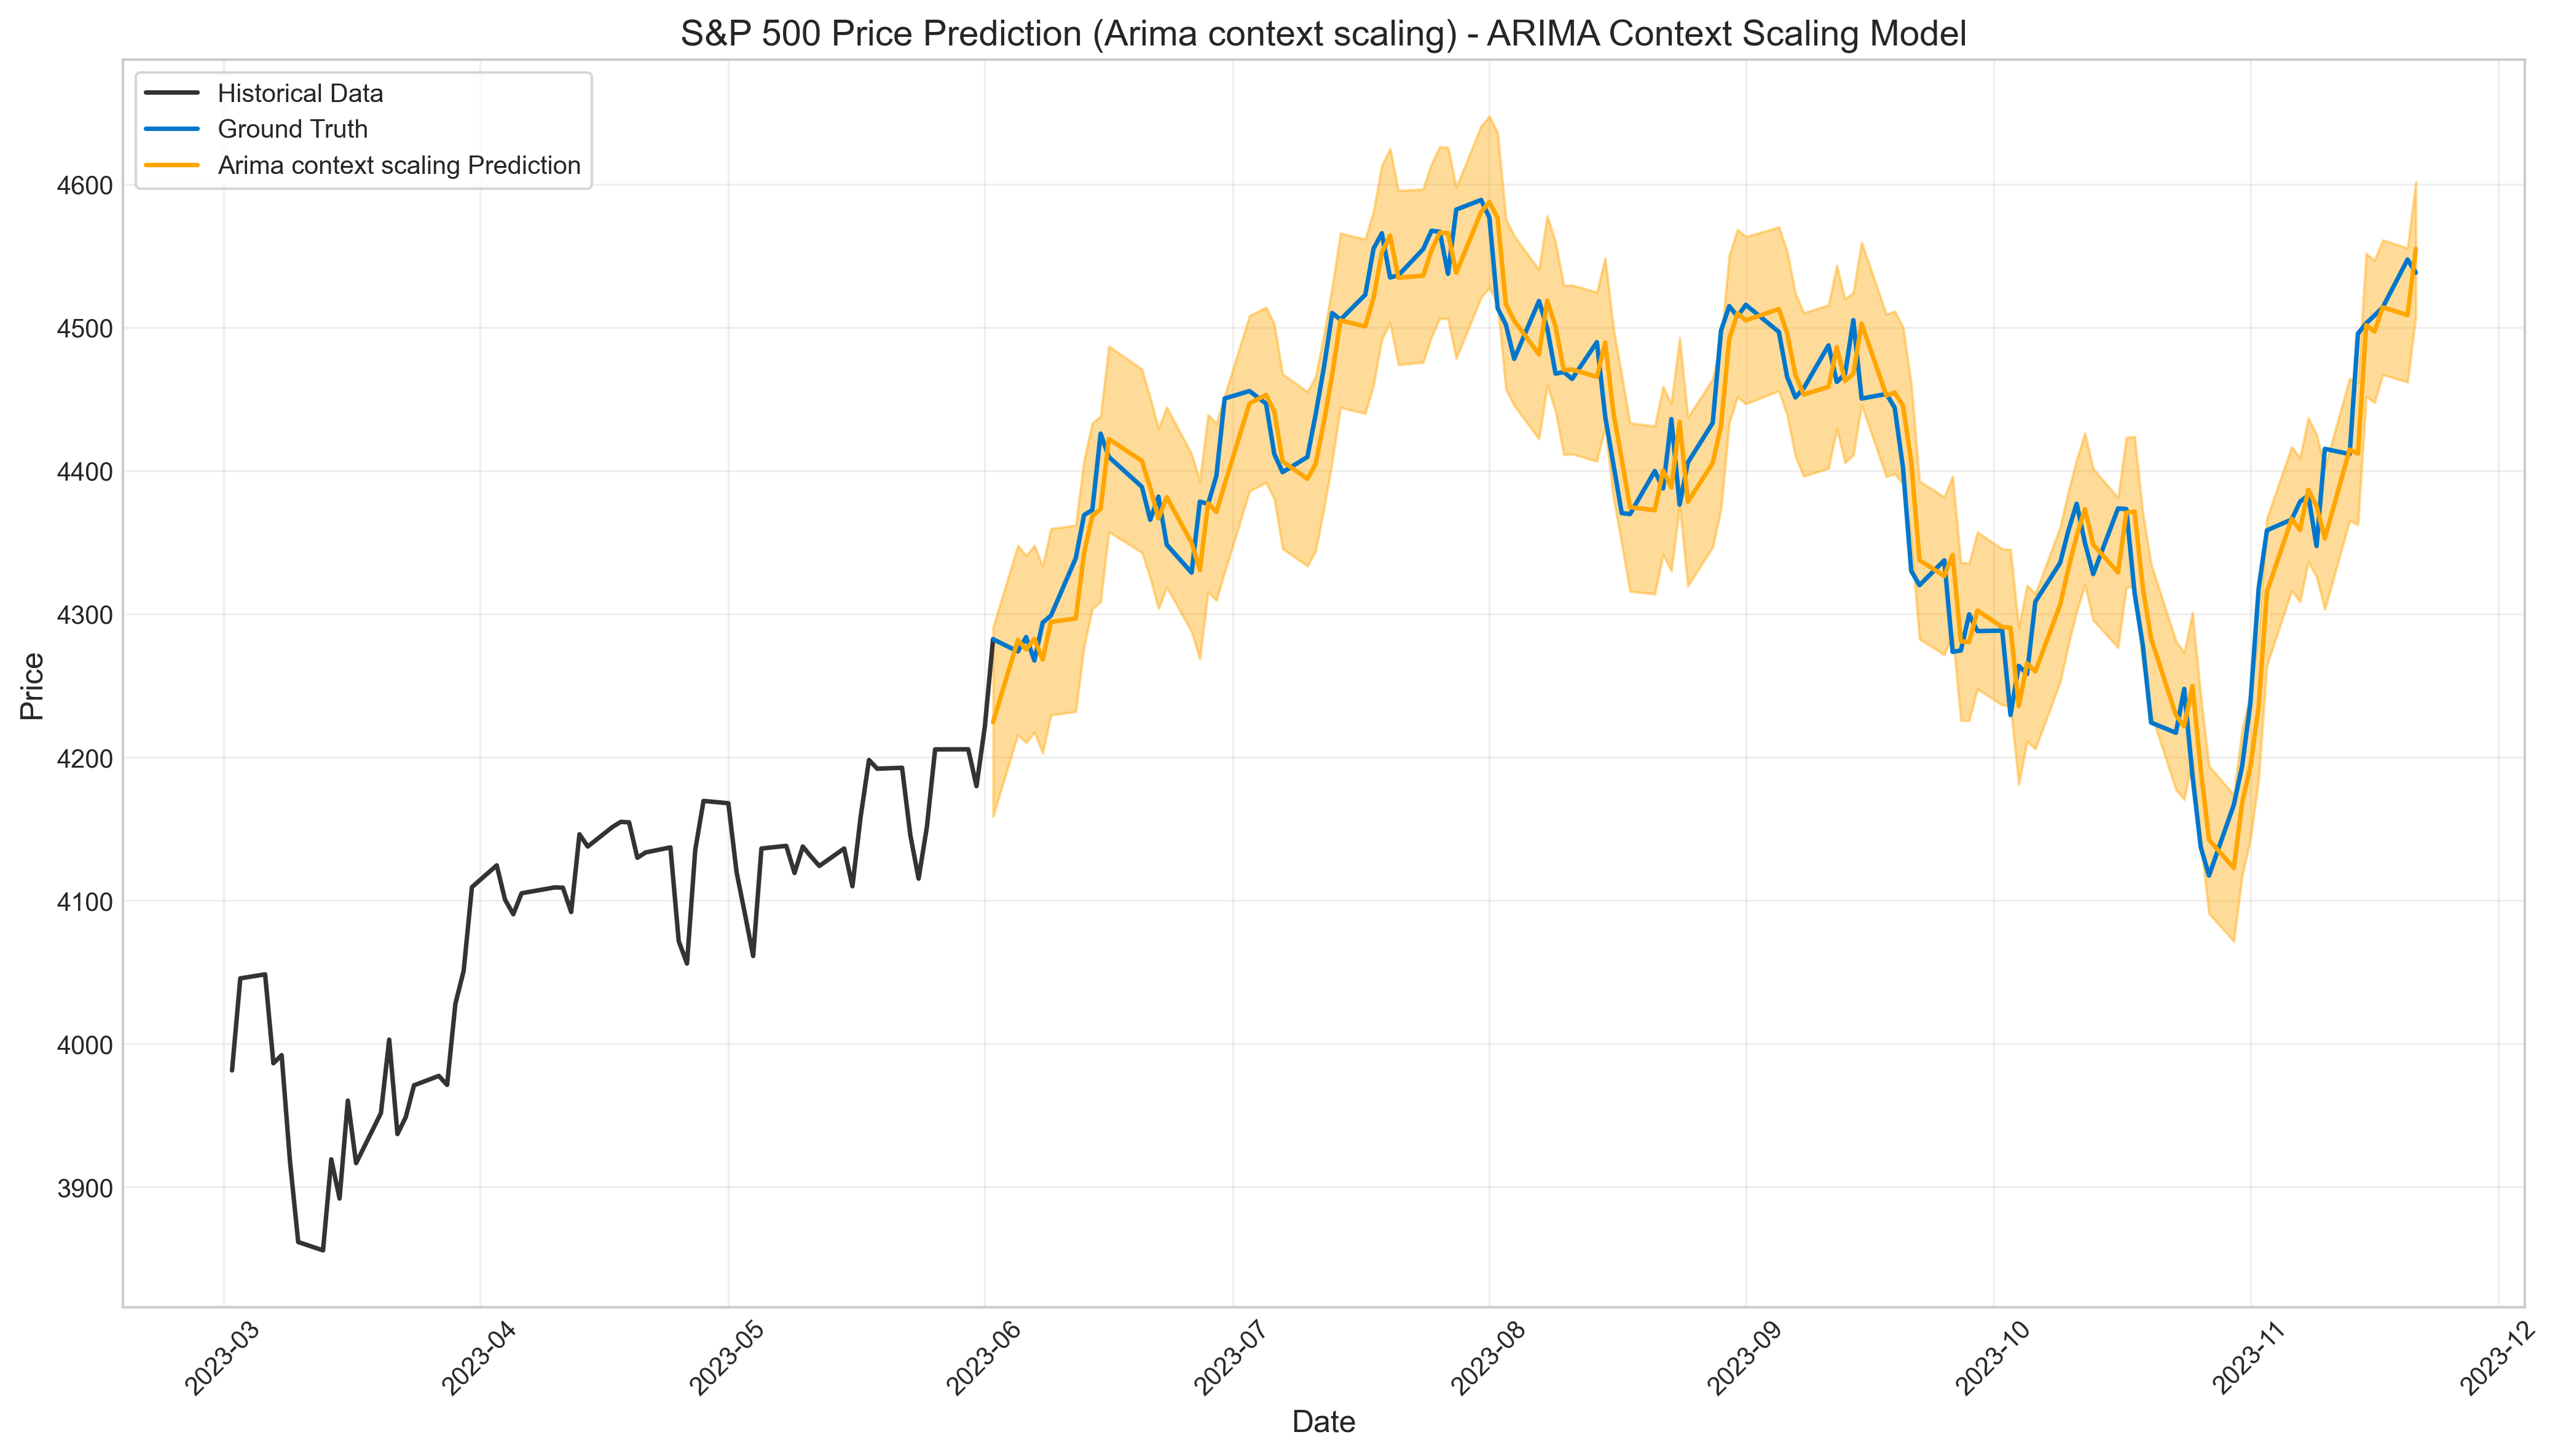

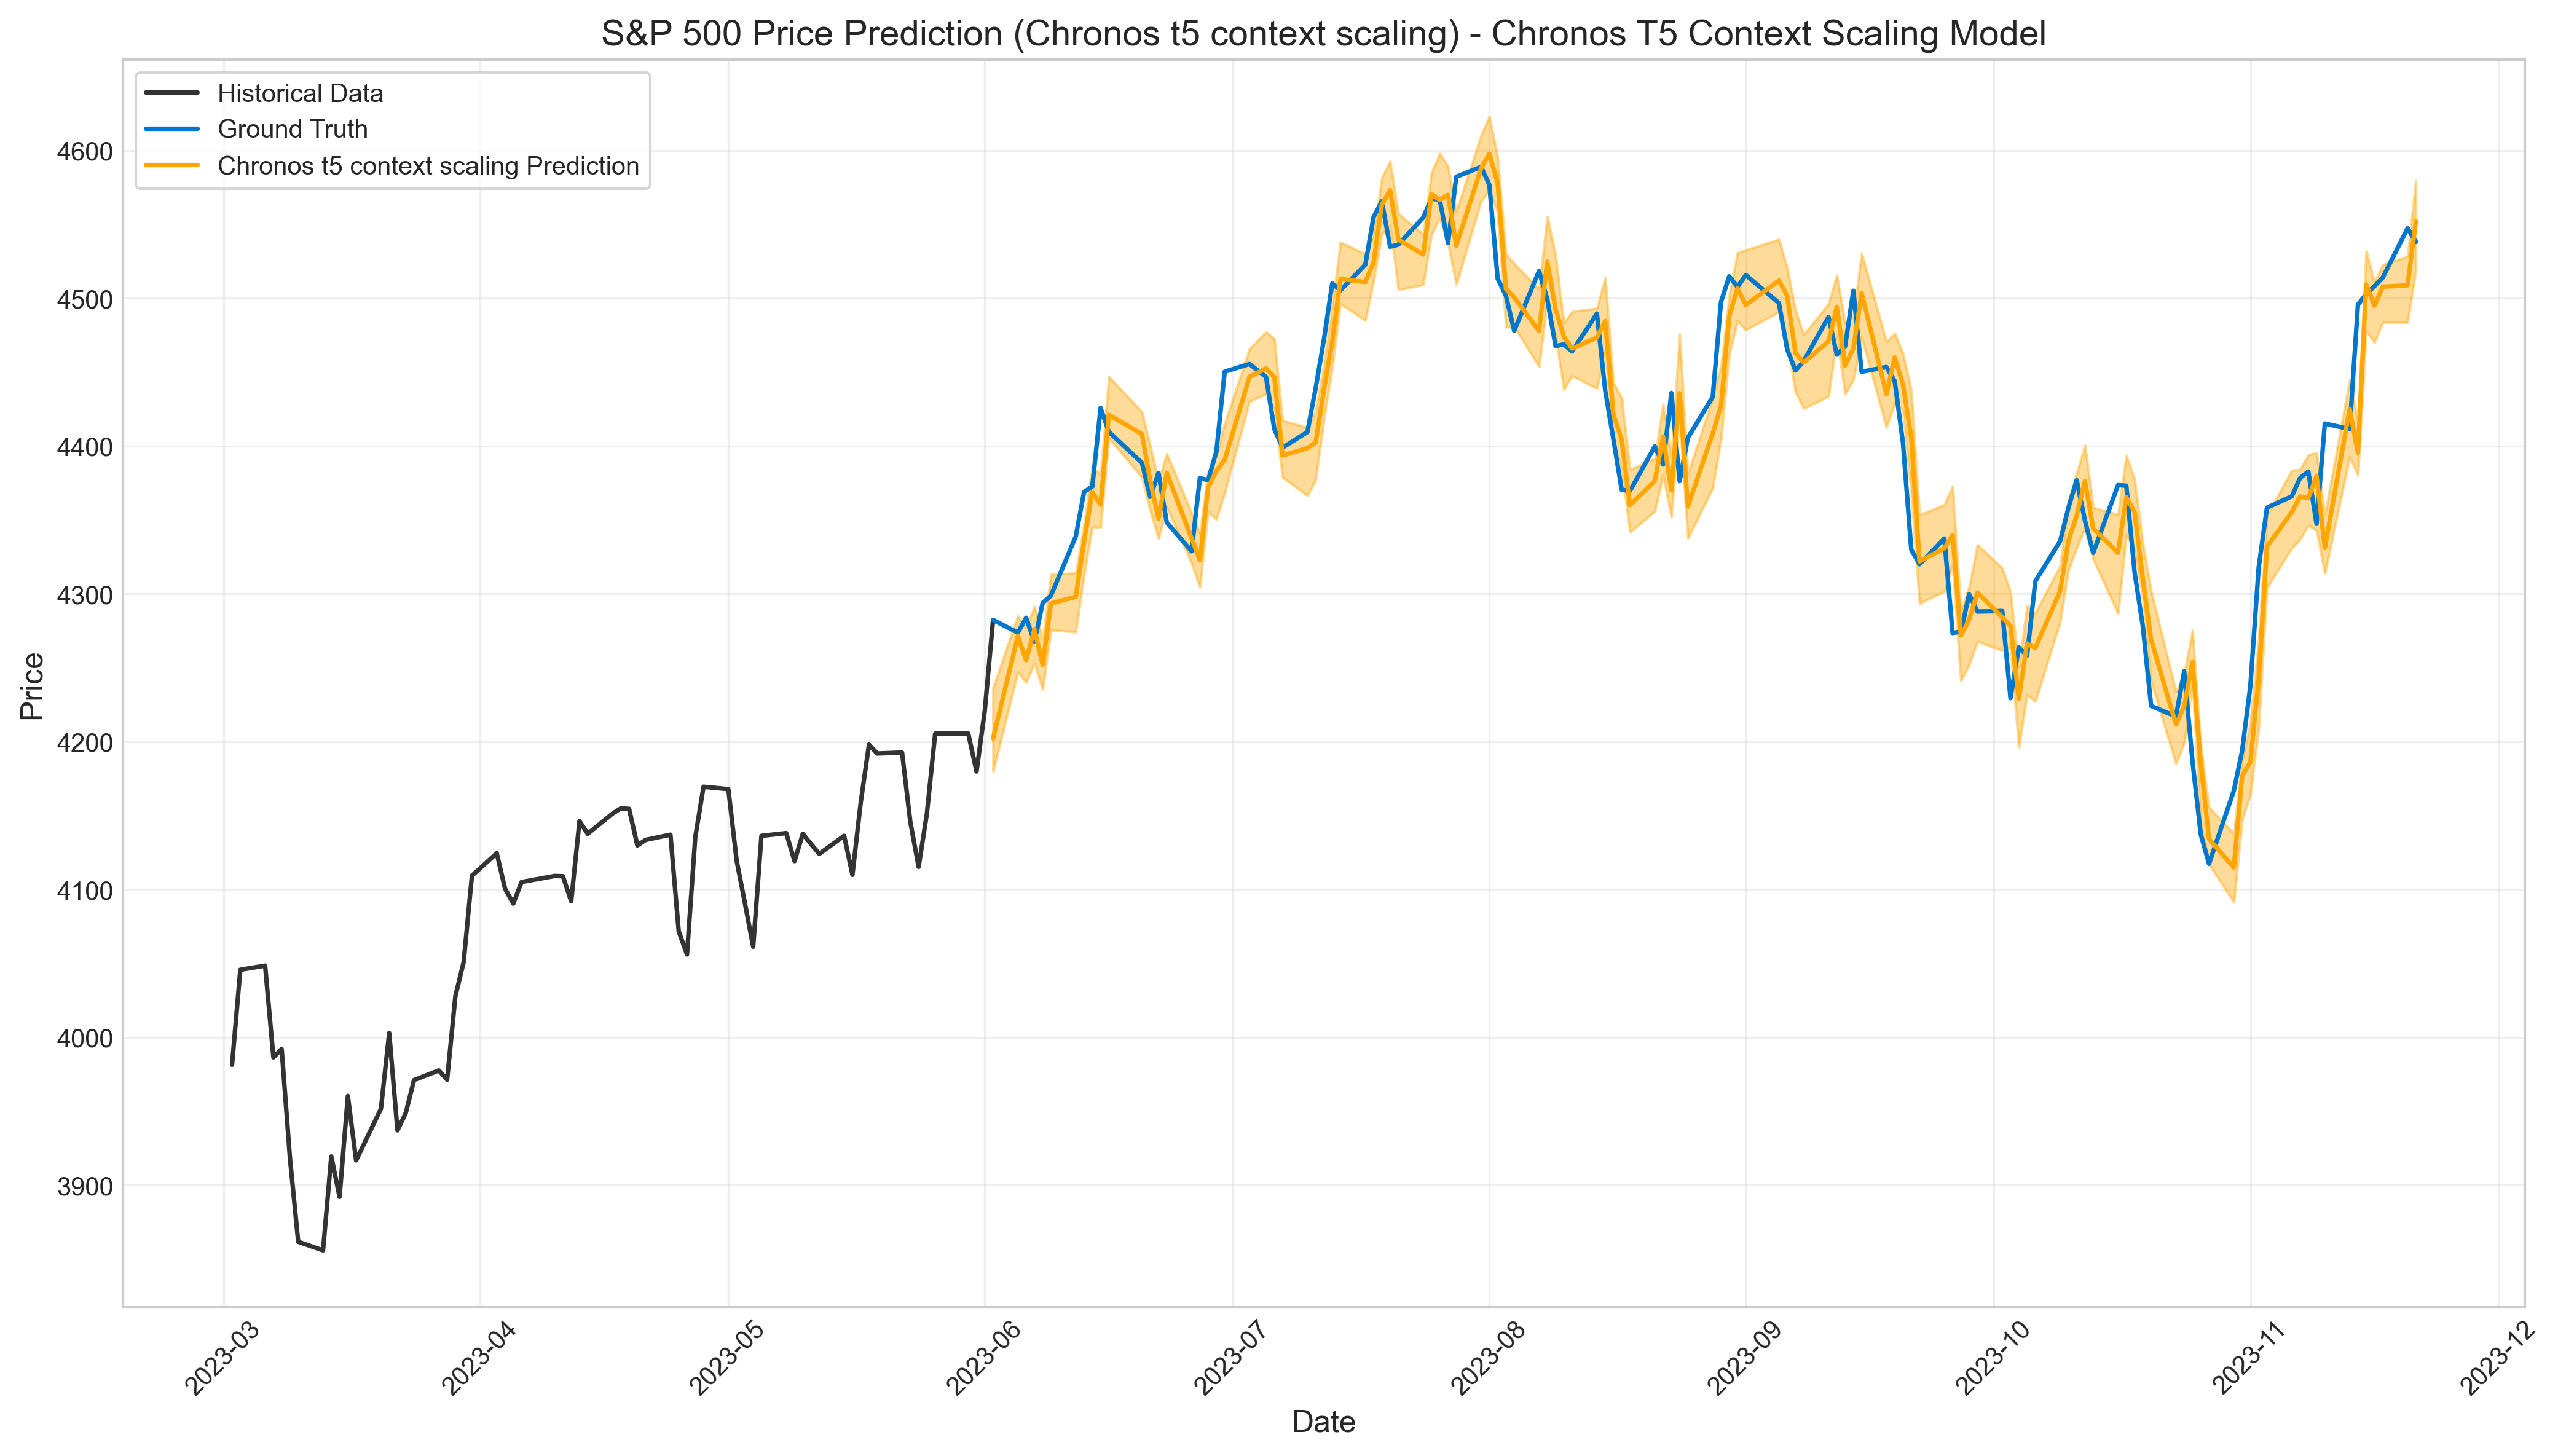

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily


CONTEXT_WINDOW = 256
FORECAST_STEPS = 120
PREDICTION_INTERVAL_ALPHA = 0.2

# ======================
# ARIMA Implementation (Context Scaling)
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=PREDICTION_INTERVAL_ALPHA))
        return ci[0][0], median, ci[0][1]

    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
        
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Context Scaling)
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts
    
    def expanding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        # For each forecast step, use all available data up to that point
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            # Use all data from the beginning up to current index
            context_data = full_data['Close'].iloc[:current_idx].values
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts


# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None

    print("\n----- DATA FOR MANUAL VALIDATION -----")
    print(f"Historical last point: {historical_last_point}")
    print(f"Actual values: {actual}")

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    
    print(f"ARIMA predictions: {arima_context_preds['median']}")
    
    # Print dates to ensure alignment
    forecast_dates = [d.strftime('%Y-%m-%d') for d in arima_context_preds['dates']]
    print(f"Forecast dates: {forecast_dates}")
    
    # Calculate metrics for ARIMA predictions
    arima_metrics = calculate_metrics(
        actual, 
        arima_context_preds['median'], 
        insample=insample_data,
        historical_last_point=historical_last_point,
        directional_accuracy=True
    )
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        
        # Ensure predictions align with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point,
            directional_accuracy=True
        )
        
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Main Entry
# ======================
def main():
    # Use the downloaded Nvidia data as an example
    data = snp500_daily
    
    # Select test start date
    test_date_str = "2023-06-01"
    test_date = pd.Timestamp(test_date_str)
    date_indices = data[data['Date'] <= test_date].index
    if len(date_indices) == 0:
        raise ValueError(f"No dates before {test_date_str} found in the dataset")
    test_start = date_indices[-1]
    
    # Run comparison
    results = run_multiple_trials_comparison(
        data, 
        n_trials=1, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
     chronos_context_avg, chronos_context_std,
     arima_context_preds,
     chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results using the new high-quality plot_forecasts function
    plot_forecasts(data, test_start, arima_context_preds, "ARIMA Context Scaling", 64, FORECAST_STEPS)
    plot_forecasts(data, test_start, chronos_context_preds, "Chronos T5 Context Scaling", 64, FORECAST_STEPS)
    
if __name__ == "__main__":
    main()

# Manual DA calculation for sanity check

In [ ]:
# Simple table showing directions
print("\n----- DIRECTIONAL ANALYSIS -----")
print("Date | Actual | Direction | Predicted | Direction | Match?")

# Ensure both arrays are flattened to 1D before concatenation
ext_actual = np.concatenate([[historical_last_point], actual.flatten()])
ext_predicted = np.concatenate([[historical_last_point], np.array(arima_context_preds['median']).flatten()])

# Print each day's comparison
for i in range(1, len(ext_actual)):
    actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
    pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
    
    # Only count non-FLAT actual movements for directional accuracy
    if actual_dir != "FLAT":
        match = "YES" if actual_dir == pred_dir else "NO"
    else:
        match = "N/A"
        
    # Print in date order (first date is missing since it's compared to historical)
    if i-1 < len(forecast_dates):
        date_str = forecast_dates[i-1]
    else:
        date_str = f"Day {i}"
        
    print(f"{date_str} | {ext_actual[i]:.2f} | {actual_dir} | {ext_predicted[i]:.2f} | {pred_dir} | {match}")

# Calculate directional accuracy manually
valid_directions = 0
correct_directions = 0

for i in range(1, len(ext_actual)):
    actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
    pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
    
    if actual_dir != "FLAT":
        valid_directions += 1
        if actual_dir == pred_dir:
            correct_directions += 1

if valid_directions > 0:
    manual_accuracy = (correct_directions / valid_directions) * 100
    print(f"\nManual directional accuracy: {correct_directions}/{valid_directions} = {manual_accuracy:.2f}%")
else:
    print("\nNo valid directions found for manual calculation")

print("----- END VALIDATION -----\n")

# TODO: test on stock and comodities data

In [ ]:
nvidia_data = yf.download("NVDA", start="2000-01-01", end="2025-02-10")
nvidia_data.reset_index(inplace=True)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])